In [4]:
import scanpy as sc
import sys
import os
import numpy as np
import pandas as pd

import mudi as md

### Load and Process Dataset

* Take the generic 10x `pbmc` dataset built into `scanpy`. 

* Process this using `mudi`'s `process` module as shown below.

In [5]:
adata = sc.datasets.pbmc3k()

adata = md.recipe(
    adata,
    min_genes=200,
    min_cells=3,
    thresh=1.75,
    mito_thresh=None,
    verbose=True,
    norm='scran'
)

	Filtering louvain group 8 - percent_mito < 0.043241834500804543
	Filtering louvain group 2 - percent_mito < 0.03154836967587471
	Filtering louvain group 0 - percent_mito < 0.03964273538440466
	Filtering louvain group 4 - percent_mito < 0.03999753319658339
	Filtering louvain group 6 - percent_mito < 0.039234081748872995
	Filtering louvain group 1 - percent_mito < 0.04667235352098942
	Filtering louvain group 5 - percent_mito < 0.055335435550659895
	Filtering louvain group 3 - percent_mito < 0.047272084979340434
	Filtering louvain group 7 - percent_mito < 0.029138509882614017
Filtered 114 / 2700 barcodes by percent_mito.


... storing 'batch' as categorical
... storing 'phase' as categorical


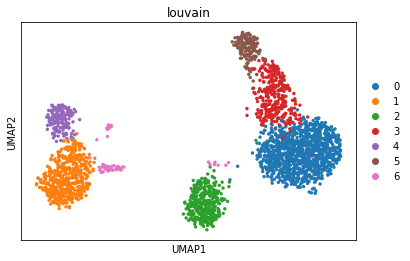

In [6]:
sc.pl.umap(adata, color='louvain')

### Import NMF Module

* `mudi` by default will use highly variable genes and pass thigs along to `signatureanalyzer`
* Call `signatureanalyzer` via `mudi.nmf`
    * **Note**: this may be greatly sped up if a GPU is available; we do not demonstrate any consensus clustering that we could complete if `nruns` > 1
    * **Note**: not fully converged - we set `max_iter` to 400 top stop optimization early
    * **Note**: you can select inputs as either `input_type=raw`, which includes normalized counts or `input_type=counts` ; use according objective function (`objective`)
    * **Note**: this was run with `inplace=True`, meaning NMF info is saved to `adata.obs` (see next cell)

In [17]:
_ = md.nmf(
        adata,
        nruns=1,
        outdir='nmf_ex',
        verbose=False,
        K0=12,
        input_type='raw',
        objective='gaussian',
        max_iter=400,
        inplace=True
    )

### Visualization & Analysis

Running `NMF` inplace stores the following:
* signature factor loadings (S1, S2, S3...) in `adata.obs`
* the NMF assigned cluster in the `nmf_id` column in `adata.obs`
* all signatures stored in `adata.uns['signatures']`
* the normalized and scaled H matrix following ARD-NMF as `adata.obsm['X_nmf']`
* marker genes determined by NMF in `adata.uns['nmf_markers']`
* all gene loadings determined by NMF in `adata.uns['nmf_genes']` (W matrix)

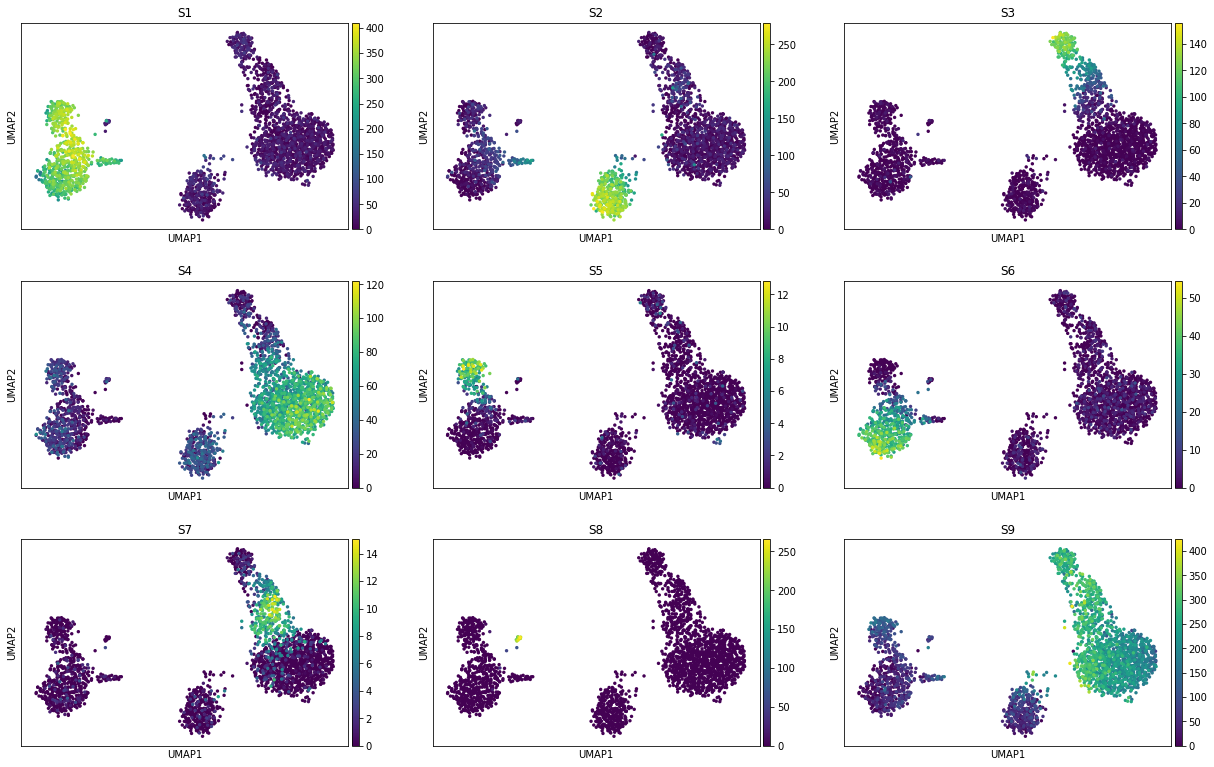

In [25]:
sc.pl.umap(adata, color=adata.uns['signatures'], ncols=3)

#### Marker Information

To easily access marker information from AnnData objects, `mudi` provies `get_uns`, which gets information from an `uns` attribute of `AnnData` and converts it into a dataframe.
* `nmf_markers`
* `nmf_genes`

In [27]:
nmf_markers = md.get_uns(adata, 'nmf_markers')
nmf_markers.head()

,ACTCGCACTACGAC-1,AGCCTCACTGTCAG-1,CGCAGGACTTGTCT-1,TGAGGTACGAACCT-1,GTAACGTGACCTCC-1,TGAGGACTCTCATT-1,TGAGCTGATGCTAG-1,TGAGCTGACTGGAT-1,CGCAGGTGCCATAG-1,TGAGCTGAATGCTG-1,...,CCTGACTGAAGTAG-1,CCTCTACTGGCATT-1,CCTCGAACTTACTC-1,CCTCGAACGTATCG-1,CCTCGAACACTTTC-1,CCTATAACTCAGAC-1,CCTATAACCAAAGA-1,CCTACCGACTCTTA-1,CCTAAGGATGATGC-1,TTTGCATGCCTCAC-1
feat,,,,,,,,,,,,,,,,,,,,,
CST3,4.327918,4.272091,4.659759,3.856432,3.761807,3.735947,0.0,4.267688,4.076704,4.354774,...,0.0,1.722734,0.000000,0.000000,0.000000,0.0,0.0,1.837787,1.60402,1.798457
TYMP,2.458200,3.332969,3.014178,1.989672,2.658257,2.477719,0.0,1.738786,2.073688,2.565540,...,0.0,0.000000,0.000000,0.000000,2.577596,0.0,0.0,0.000000,0.00000,0.000000
CTSS,2.458200,3.172382,3.014178,2.992697,3.653312,3.240896,0.0,0.000000,2.532917,3.006291,...,0.0,1.722734,1.421104,1.971897,1.957659,0.0,0.0,0.000000,0.00000,2.405200
NPC2,1.847175,3.172382,1.918642,2.992697,2.802348,2.217630,0.0,2.983747,2.532917,2.734966,...,0.0,0.000000,1.421104,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.000000
PYCARD,1.847175,1.640382,2.168932,1.989672,1.690797,1.316010,0.0,2.339964,2.329435,2.361434,...,0.0,0.000000,1.421104,0.000000,1.957659,0.0,0.0,0.000000,0.00000,1.798457


In [30]:
nmf_genes = md.get_uns(adata, 'nmf_genes')
nmf_genes.head()

,S1,S2,S3,S4,S5,S6,S7,S8,S9,max,max_id,max_norm,mean_on,mean_off,diff
index,,,,,,,,,,,,,,,
CST3,0.011863,1.350182e-09,6.932460e-09,1.410623e-04,1.196395e-04,5.424325e-03,0.000000e+00,0.004575,0.000630,0.011863,1.0,0.883861,3.922777,0.349449,3.573328
TYMP,0.007503,2.795401e-04,2.863834e-04,5.941543e-11,5.442706e-04,3.626768e-03,0.000000e+00,0.000000,0.000628,0.007503,1.0,0.836841,2.485375,0.263830,2.221545
CTSS,0.008764,3.196859e-03,1.734978e-03,4.589517e-03,5.933201e-05,8.962771e-07,9.640933e-43,0.000000,0.000736,0.008764,1.0,0.645505,2.908974,0.704158,2.204816
NPC2,0.006912,1.616893e-03,4.836208e-09,2.553447e-03,3.324433e-04,1.150171e-08,0.000000e+00,0.000096,0.000679,0.006912,1.0,0.701337,2.271840,0.460036,1.811804
PYCARD,0.005659,9.461647e-04,2.816834e-03,1.778973e-05,3.302218e-07,1.264431e-08,4.787300e-38,0.000000,0.001049,0.005659,1.0,0.695354,1.852286,0.384248,1.468038
